<a href="https://colab.research.google.com/github/nasirbashak/Plant-the-future/blob/master/Normal_Regression_Model_with_40_MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow==2.0.0b1
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 42kB/s 
     |████████████████████████████████| 3.9MB 52.0MB/s 
     |████████████████████████████████| 450kB 59.4MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
import pandas as pd
print(tf.__version__)

2.1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
df = pd.read_csv("Traffic_density_day_by_day_2000_to_2019_version2.csv")
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2000-1,2406,5469,2244,1899,1239,355,1467,1639,2311,1486,2253,1735,648,937,1432,4944,6664,1144,1010,3154,2029,1971,5299,4072,400,2299,2690,2212,3795,6651,782,7860,1424,2498,318,710,1858,1596,1253,...,895,7019,1460,1689,1456,7751,2027,6888,1140,7363,644,1773,1084,1998,1280,6027,477,916,2090,1834,1564,2081,1545,1911,678,805,9955,816,1603,202,265,838,8432,1801,743,318,2101,678,6695,1288
1,2000-2,2328,5452,2275,1891,1226,336,1447,1685,2269,1516,2222,1749,642,936,1453,4938,6663,1131,982,3157,2029,2021,5308,4083,357,2302,2693,2240,3807,6648,811,7850,1556,2501,311,710,1867,1579,1201,...,813,7018,1404,1778,1470,7750,2015,6886,1126,7367,604,1716,1081,2006,1341,6024,515,912,2079,1857,1590,2052,1579,1907,660,736,9957,791,1587,240,253,897,8433,1823,746,331,2053,692,6693,1342
2,2000-3,2269,5423,2273,1849,1235,312,1430,1672,2242,1549,2168,1799,619,915,1466,4938,6663,1134,954,3160,2019,2054,5323,4103,339,2305,2695,2281,3802,6639,832,7839,1631,2503,307,724,1828,1555,1144,...,742,7013,1307,1797,1477,7748,2013,6880,1083,7372,575,1722,1088,1986,1347,6021,542,889,2075,1786,1618,2010,1618,1854,755,648,9954,701,1582,241,236,901,8432,1851,758,390,1976,696,6688,1379
3,2000-4,2187,5405,2272,1835,1292,281,1401,1624,2266,1580,2123,1846,588,902,1516,4941,6666,1134,953,3163,2028,2108,5336,4128,344,2308,2697,2291,3787,6640,809,7831,1659,2506,320,847,1843,1484,1095,...,692,7006,1220,1775,1512,7744,2005,6875,1047,7378,536,1746,1087,2035,1402,6020,541,879,2064,1794,1624,1972,1659,1882,835,571,9958,709,1581,247,247,892,8431,1861,741,469,1829,686,6679,1430
4,2000-5,2107,5401,2255,1841,1404,254,1372,1565,2241,1642,2092,1859,544,888,1587,4955,6670,1126,1012,3166,2041,2203,5346,4141,338,2311,2700,2318,3774,6628,846,7820,1732,2509,313,993,1832,1392,1055,...,699,7007,1139,1759,1542,7744,1972,6875,1041,7385,537,1755,1099,2025,1468,6025,533,863,2063,1801,1620,1943,1643,1805,812,560,9963,718,1571,269,230,969,8429,1810,764,535,1678,680,6677,1472


In [0]:
df.rename(columns={"Unnamed: 0":"Days"},inplace=True)

In [0]:
df.head()

,Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2000-1,2406,5469,2244,1899,1239,355,1467,1639,2311,1486,2253,1735,648,937,1432,4944,6664,1144,1010,3154,2029,1971,5299,4072,400,2299,2690,2212,3795,6651,782,7860,1424,2498,318,710,1858,1596,1253,...,895,7019,1460,1689,1456,7751,2027,6888,1140,7363,644,1773,1084,1998,1280,6027,477,916,2090,1834,1564,2081,1545,1911,678,805,9955,816,1603,202,265,838,8432,1801,743,318,2101,678,6695,1288
1,2000-2,2328,5452,2275,1891,1226,336,1447,1685,2269,1516,2222,1749,642,936,1453,4938,6663,1131,982,3157,2029,2021,5308,4083,357,2302,2693,2240,3807,6648,811,7850,1556,2501,311,710,1867,1579,1201,...,813,7018,1404,1778,1470,7750,2015,6886,1126,7367,604,1716,1081,2006,1341,6024,515,912,2079,1857,1590,2052,1579,1907,660,736,9957,791,1587,240,253,897,8433,1823,746,331,2053,692,6693,1342
2,2000-3,2269,5423,2273,1849,1235,312,1430,1672,2242,1549,2168,1799,619,915,1466,4938,6663,1134,954,3160,2019,2054,5323,4103,339,2305,2695,2281,3802,6639,832,7839,1631,2503,307,724,1828,1555,1144,...,742,7013,1307,1797,1477,7748,2013,6880,1083,7372,575,1722,1088,1986,1347,6021,542,889,2075,1786,1618,2010,1618,1854,755,648,9954,701,1582,241,236,901,8432,1851,758,390,1976,696,6688,1379
3,2000-4,2187,5405,2272,1835,1292,281,1401,1624,2266,1580,2123,1846,588,902,1516,4941,6666,1134,953,3163,2028,2108,5336,4128,344,2308,2697,2291,3787,6640,809,7831,1659,2506,320,847,1843,1484,1095,...,692,7006,1220,1775,1512,7744,2005,6875,1047,7378,536,1746,1087,2035,1402,6020,541,879,2064,1794,1624,1972,1659,1882,835,571,9958,709,1581,247,247,892,8431,1861,741,469,1829,686,6679,1430
4,2000-5,2107,5401,2255,1841,1404,254,1372,1565,2241,1642,2092,1859,544,888,1587,4955,6670,1126,1012,3166,2041,2203,5346,4141,338,2311,2700,2318,3774,6628,846,7820,1732,2509,313,993,1832,1392,1055,...,699,7007,1139,1759,1542,7744,1972,6875,1041,7385,537,1755,1099,2025,1468,6025,533,863,2063,1801,1620,1943,1643,1805,812,560,9963,718,1571,269,230,969,8429,1810,764,535,1678,680,6677,1472


Series shape (7305,)
Time shape (7305,)


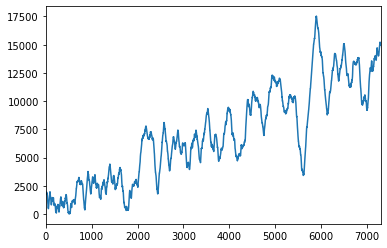

In [0]:
df.iloc[:,4].plot()
series = df.iloc[:,4]
time = np.array(range(len(series)))
print("Series shape",series.shape)
print("Time shape",time.shape)

In [0]:
series = np.array(series)

In [0]:
split_time = 5600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 128
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      #strides=1, padding="causal",
                      #activation="relu",
                      #input_shape=[None, 1]),
  #tf.keras.layers.LSTM(64, return_sequences=True,input_shape=[None, 1]),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu",input_shape=[None, 1]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.int64, tf.int64)>
(5600,)
Epoch 1/100
44/44 [==============================] - 2s 36ms/step - loss: 4552.9590 - mae: 4509.3828
Epoch 2/100
44/44 [==============================] - 1s 25ms/step - loss: 4354.3177 - mae: 4327.2529
Epoch 3/100
44/44 [==============================] - 1s 24ms/step - loss: 4150.7462 - mae: 4116.6299
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 3933.7163 - mae: 3902.3533
Epoch 5/100
44/44 [==============================] - 1s 23ms/step - loss: 3679.0978 - mae: 3647.4719
Epoch 6/100
44/44 [==============================] - 1s 23ms/step - loss: 3365.1151 - mae: 3335.6406
Epoch 7/100
44/44 [==============================] - 1s 23ms/step - loss: 2970.4164 - mae: 2946.0732
Epoch 8/100
44/44 [==============================] - 1s 23ms/step - loss: 2460.1963 - mae: 2447.5183
Epoch 9/100
44/44 [==============================] - 1s 23ms/step - loss: 1795.9258 - mae: 179

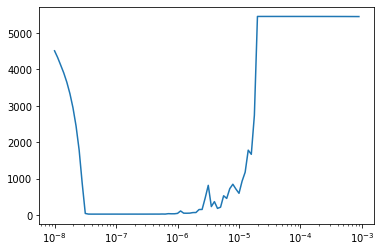

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
bestLr = history.history['lr'][np.argmin(history.history['loss'])]
bestLr

7.943282e-08

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=60, kernel_size=5,
  #                    strides=1, padding="causal",
  #                    activation="relu",
  #                    input_shape=[None, 1]),
  #tf.keras.layers.LSTM(60, return_sequences=True,input_shape=[None, 1]),
  #tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu",input_shape=[None, 1]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=bestLr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
44/44 [==============================] - 1s 33ms/step - loss: 4168.3205 - mae: 4143.2378
Epoch 2/500
44/44 [==============================] - 1s 25ms/step - loss: 2679.9122 - mae: 2678.0469
Epoch 3/500
44/44 [==============================] - 1s 23ms/step - loss: 482.3862 - mae: 488.7050
Epoch 4/500
44/44 [==============================] - 1s 23ms/step - loss: 52.9370 - mae: 53.6754
Epoch 5/500
44/44 [==============================] - 1s 22ms/step - loss: 33.9575 - mae: 34.4771
Epoch 6/500
44/44 [==============================] - 1s 22ms/step - loss: 33.7030 - mae: 34.2228
Epoch 7/500
44/44 [==============================] - 1s 23ms/step - loss: 33.6532 - mae: 34.1931
Epoch 8/500
44/44 [==============================] - 1s 23ms/step - loss: 33.7761 - mae: 34.3140
Epoch 9/500
44/44 [==============================] - 1s 23ms/step - loss: 33.8765 - mae: 34.4078
Epoch 10/500
44/44 [==============================] - 1s 24ms/step - loss: 33.8455 - mae: 34.3260
Epoch 11/500
44/44 

<Figure size 432x288 with 0 Axes>

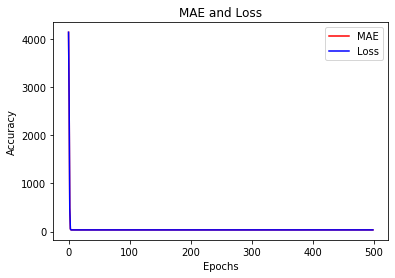

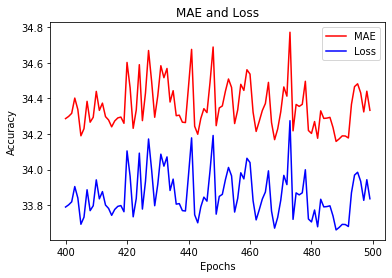

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[400:]
mae_zoom = mae[400:]
loss_zoom = loss[400:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast2 = rnn_forecast2[ window_size:split_time, -1, 0]

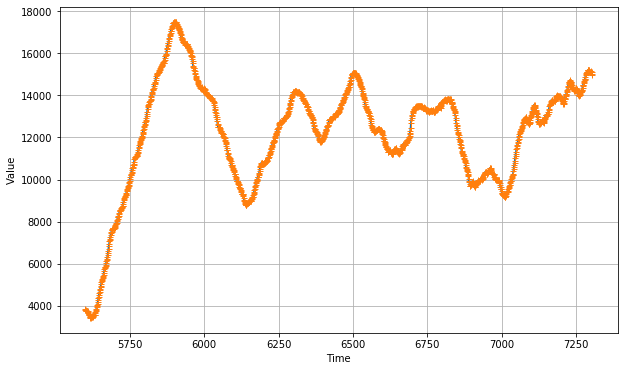

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast,format='+')

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

40.054092

In [0]:
print(rnn_forecast)

[ 3865.0486  3802.081   3777.093  ... 15118.365  15035.407  14986.433 ]


In [0]:
model.save("Normal Regression.h5")

In [0]:
model = tf.keras.models.load_model("Normal Regression.h5")

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

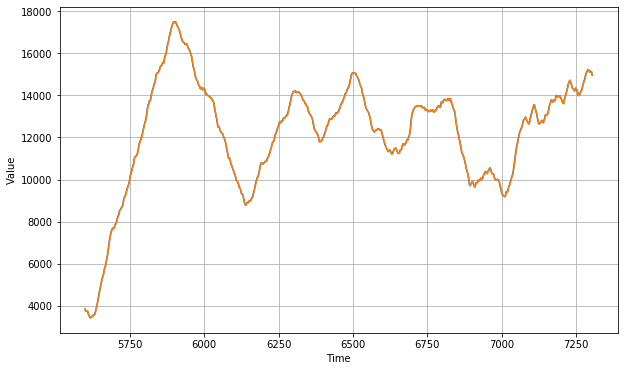

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast,format='-')

Series shape (7305,)
Time shape (7305,)


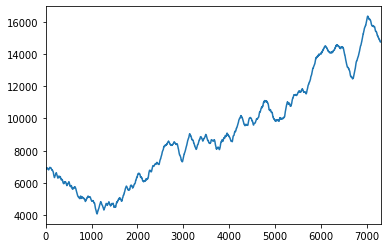

In [0]:
column = 55

df.iloc[:,column].plot()
series = df.iloc[:,column]
time = np.array(range(len(series)))
print("Series shape",series.shape)
print("Time shape",time.shape)

In [0]:
series = np.array(series)
time = np.array(time)

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[:-1, -1, 0]
print("Shape of forecast",rnn_forecast.shape)

Shape of forecast (7241,)


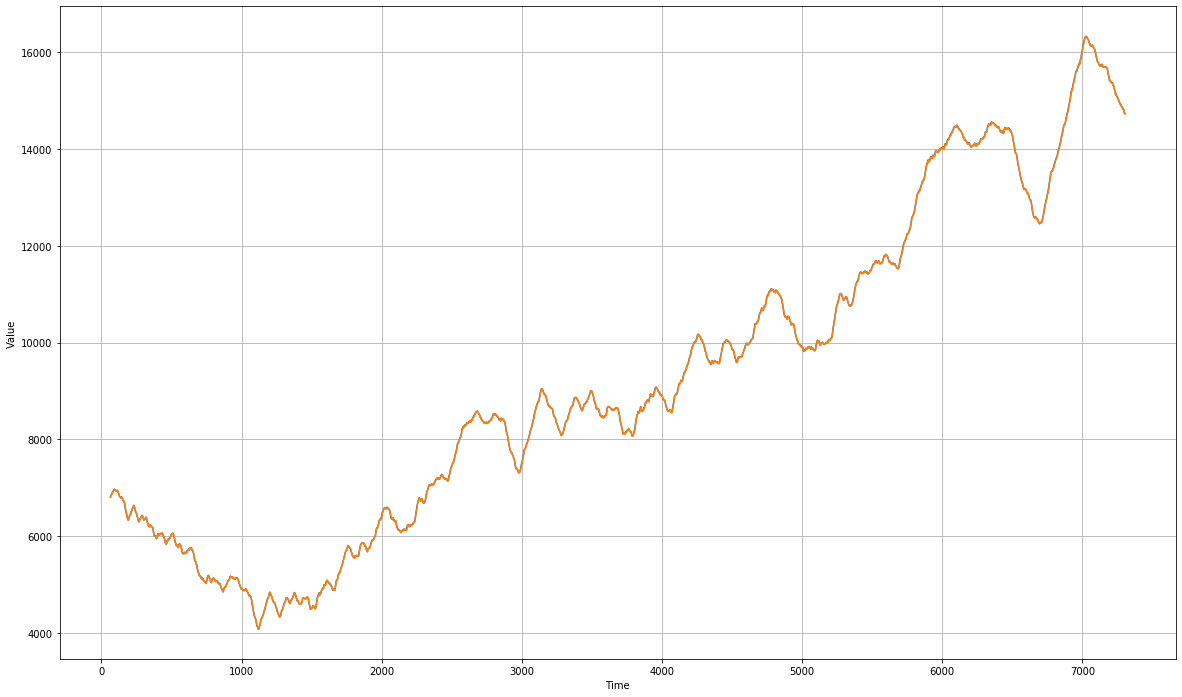

In [0]:
plt.figure(figsize=(20, 12))
plot_series(time[window_size:], series[window_size:],)
plot_series(time[window_size:], rnn_forecast,format='-')

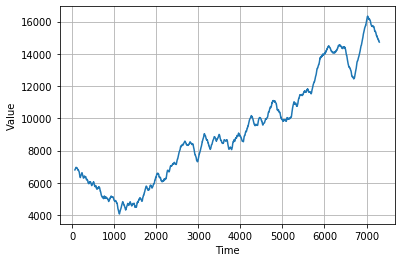

In [0]:
plot_series(time[window_size:], rnn_forecast,format='-')